In [1]:

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split , GridSearchCV ,RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

%matplotlib inline

In [2]:

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


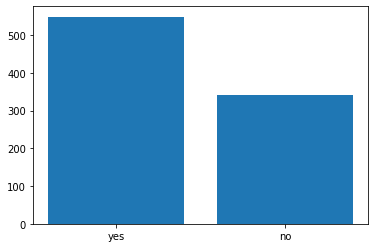

In [3]:
grouped = train_df.groupby('Survived')
survived_counts = grouped.count()

plt.bar([0,1] , survived_counts['PassengerId'])
_ = plt.xticks([0,1] , ['yes','no'])

In [4]:
def prepare_features(train_df , test_df):
    res = []
    for i , df in enumerate([train_df , test_df]):
        X = pd.get_dummies(df['Pclass'] , prefix='Pclass')

        title = np.zeros(len(df))    
        title[df['Name'].str.contains('Mr.')] = 1
        title[df['Name'].str.contains('Mrs.')] = 2
        title[df['Name'].str.contains('Miss.')] = 3
        X = pd.concat([X,pd.get_dummies(title , prefix='Title')] , axis = 1)
        age = df['Age']
        if i == 0:
            age_avg = age.mean()
        age.fillna(age_avg , inplace = True)
        X['AgeRounded'] = round(df['Age']/20).astype(int)
        X['Sex'] = (df['Sex'] == 'female').astype(int)

        X['SibSpBin'] = (df['SibSp'] > 0).astype(int)
        X['ParchBin'] =(df['Parch'] > 0).astype(int)

        X['HadCabin']  = (df['Cabin'].isna()).astype(int)    
        X['Fare'] = df['Fare']
        X['Fare'].fillna(20 , inplace = True)

        embarked = np.zeros(len(df))
        embarked[df['Embarked'] == 'Q'] = 1
        embarked[df['Embarked'] == 'S'] = 2

        X = pd.concat([X,pd.get_dummies(embarked , prefix='Embarked')] , axis = 1)
        res.append(X)
    
    X_train = res[0]
    X_test = res[1]
    return X_train , X_test

def feature_analysis(col):
    grouped = train_df.groupby(col)
    counts = grouped.count()['Survived']
    target_rate = grouped.mean()['Survived']

    x = np.arange(len(counts))
    plt.subplot(1,2,1)
    plt.bar( x, counts)
    plt.xticks(x, counts.index)
    plt.title(col + ' counts')
    plt.subplot(1,2,2)
    plt.bar(x, target_rate)
    plt.xticks(x, target_rate.index)
    plt.title(col + ' rates')
    

def create_submission(name , ids , predictions):
    df_sub = pd.DataFrame.from_dict({'PassengerId' : ids , 'Survived' : predictions})
    df_sub.to_csv('sub_' + name + '.csv' , index = False)

## Feature Eng.

### Pclass

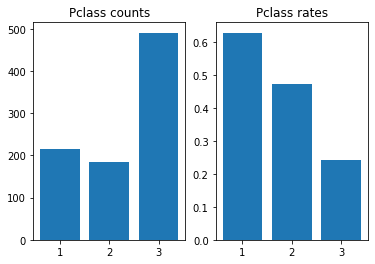

In [5]:
train_df['Pclass'].unique()
    
feature_analysis('Pclass')

### Name

Title
0.0     64
1.0    518
2.0    127
3.0    182
Name: PassengerId, dtype: int64


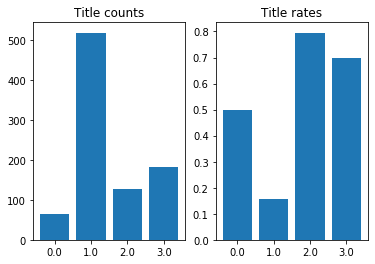

In [6]:
title = np.zeros(len(train_df))

# other title are small groups
title[train_df['Name'].str.contains('Mr.')] = 1
title[train_df['Name'].str.contains('Mrs.')] = 2
title[train_df['Name'].str.contains('Miss.')] = 3
# title[train_df['Name'].str.contains('Master.')] = 4

train_df['Title'] = title
print(train_df.groupby('Title')['PassengerId'].count())

feature_analysis('Title')




### Age

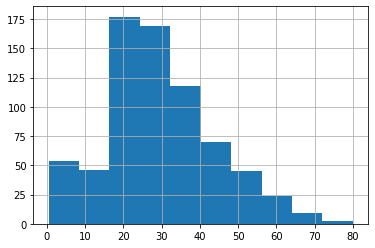

In [7]:
train_df['Age'].hist()

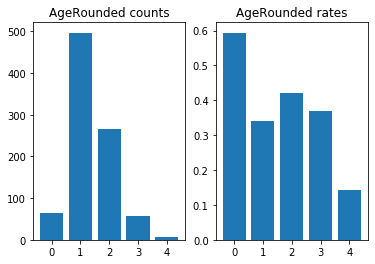

In [8]:
train_df['Age'].fillna(train_df['Age'].mean() , inplace = True)
train_df['AgeRounded'] = round(train_df['Age']/20).astype(int)

feature_analysis('AgeRounded')

### Sex

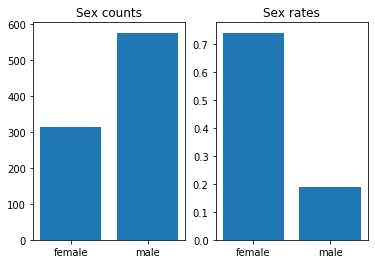

In [9]:
feature_analysis('Sex')

### Siblings

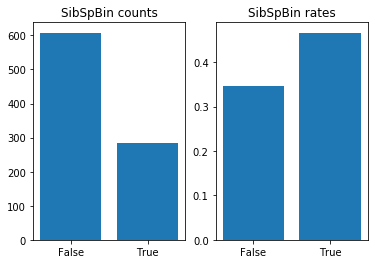

In [10]:
train_df['SibSpBin'] = train_df['SibSp'] > 0
feature_analysis('SibSpBin')

### Parch

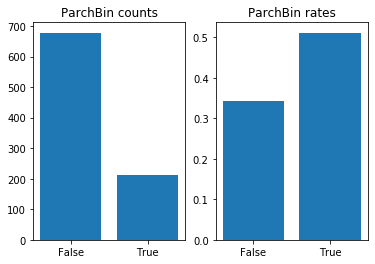

In [11]:
train_df['ParchBin'] = train_df['Parch'] > 0
feature_analysis('ParchBin')

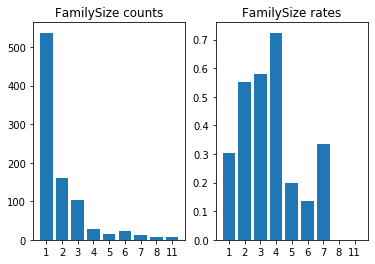

In [12]:
train_df['FamilySize'] = train_df['Parch'] +train_df['SibSp'] + 1
feature_analysis('FamilySize')

### Cabin

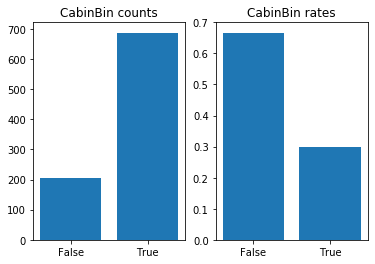

In [13]:
train_df['CabinShort'] = train_df['Cabin']
train_df['CabinShort'] = train_df['CabinShort'].fillna('X')
train_df['CabinShort'] = train_df['CabinShort'].str[0]

train_df['CabinBin'] = train_df['Cabin'].isna()

feature_analysis('CabinBin')

### Embarked

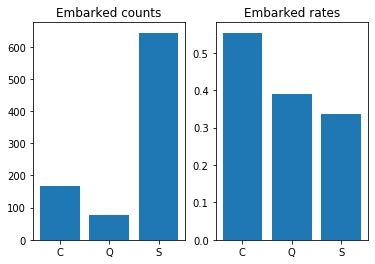

In [14]:
feature_analysis('Embarked')

In [15]:

X_train , X_test = prepare_features(train_df , test_df)
y_train = train_df['Survived']

X_train.head(10)


,Pclass_1,Pclass_2,Pclass_3,Title_0.0,Title_1.0,Title_2.0,Title_3.0,AgeRounded,Sex,SibSpBin,ParchBin,HadCabin,Fare,Embarked_0.0,Embarked_1.0,Embarked_2.0
0,0,0,1,0,1,0,0,1,0,1,0,1,7.2500,0,0,1
1,1,0,0,0,0,1,0,2,1,1,0,0,71.2833,1,0,0
2,0,0,1,0,0,0,1,1,1,0,0,1,7.9250,0,0,1
3,1,0,0,0,0,1,0,2,1,1,0,0,53.1000,0,0,1
4,0,0,1,0,1,0,0,2,0,0,0,1,8.0500,0,0,1
5,0,0,1,0,1,0,0,1,0,0,0,1,8.4583,0,1,0
6,1,0,0,0,1,0,0,3,0,0,0,0,51.8625,0,0,1
7,0,0,1,1,0,0,0,0,0,1,1,1,21.0750,0,0,1
8,0,0,1,0,0,1,0,1,1,0,1,1,11.1333,0,0,1
9,0,1,0,0,0,1,0,1,1,1,0,1,30.0708,1,0,0


In [16]:
def cross_val_test(clf , X_train , y_train):
    cv_res = cross_val_score(clf,X_train, y_train , cv = 4 , scoring = 'accuracy')
    print(f'cross validation mean = {cv_res.mean()}')
    print(f'cross validation std = {cv_res.std()}')
    

In [17]:
lr_clf = LogisticRegression(C = 100 , solver = 'liblinear')
res = cross_val_test(lr_clf,X_train, y_train)


cross validation mean = 0.8170656893680998
cross validation std = 0.012348250758819807


In [18]:
param_grid={'solver' : ['liblinear'],'penalty' : ['l1', 'l2'],'C' : [0.01 ,0.05, 0.1 , 0.2, 0.5 ,1 ,5,10 ,20,30,40, 100]}
grid_search = GridSearchCV(estimator=LogisticRegression(),cv=4,param_grid=param_grid,  verbose=1)
grid_search_res = grid_search.fit(X_train , y_train)
print(f'best params : {grid_search_res.best_params_}')
print(f'best params : {grid_search_res.best_score_}')

cross_val_test(grid_search_res.best_estimator_,X_train, y_train)


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best params : {'C': 20, 'penalty': 'l1', 'solver': 'liblinear'}
best params : 0.8181818181818182
cross validation mean = 0.8181817607966712
cross validation std = 0.0116644737868191


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    0.7s finished


In [19]:
rf_clf = RandomForestClassifier(n_estimators=500,max_depth = 5 , min_samples_leaf=2 , verbose=True)
cross_val_test(rf_clf,X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cross validation mean = 0.8204490274627607
cross validation std = 0.015871535211529522


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


In [21]:

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(),cv=4,param_distributions=param_grid,  
                                 n_iter = 200,n_jobs=4,verbose=1)
rf_grid_search.fit(X_train , y_train)
print(f'best params : {rf_grid_search.best_params_}')
print(f'best params : {rf_grid_search.best_score_}')

cross_val_test(rf_grid_search.best_estimator_,X_train, y_train)



Fitting 4 folds for each of 200 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:  5.0min finished


best params : {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}
best params : 0.8305274971941639
cross validation mean = 0.8271655203409688
cross validation std = 0.015619811665501622


In [ ]:
rf_clf = RandomForestClassifier(**rf_grid_search.best_params_)
rf_clf.fit(X_train , y_train)
preds = rf_clf.predict(X_test)
create_submission('rf_grid' , test_df['PassengerId'] , preds)


In [ ]:
rf_clf.fit(X_train , y_train)
preds = rf_clf.predict(X_test)
create_submission('rf' , test_df['PassengerId'] , preds)

In [23]:
xgb_clf = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
cross_val_test(xgb_clf , X_train , y_train)
# xgb_clf.fit(X_train , y_train)

cross validation mean = 0.828336915150256
cross validation std = 0.020118618369619375


In [ ]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear' , 'rbf']
param_grid = {'C': Cs, 'gamma' : gammas , 'kernel' : kernels}


svc_grid_search = GridSearchCV(SVC(), param_grid, cv=4 , verbose = 1 , n_jobs=4)
svc_grid_search.fit(X_train, y_train)
cross_val_test(svc_grid_search.best_estimator_,X_train, y_train)

In [28]:
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[50, 100 ,300 ,500 ,1000 ,1500]
    }

gbc_rnd_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),cv=4, n_jobs=4,
                                param_distributions=param_grid,n_iter = 200,verbose=1)

gbc_rnd_search.fit(X_train , y_train)
cross_val_test(gbc_rnd_search.best_estimator_,X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 206 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done 456 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:  2.1min finished
C:\Users\avish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


cross validation mean = 0.8260896677026162
cross validation std = 0.022929336746432775


In [ ]:
preds = gbc_rnd_search.best_estimator_.predict(X_test)
create_submission('gradient_boosting' , test_df['PassengerId'] , preds)

In [44]:
estimators = [('rf' , RandomForestClassifier(**rf_grid_search.best_params_) ),
              ('xgb' , xgb_clf),
              ('gbc' , GradientBoostingClassifier(**gbc_rnd_search.best_params_) )]

for est in estimators:
    est[1].fit(X_train , y_train)

voting_clf = VotingClassifier(estimators)
voting_clf.fit(X_train , y_train)

In [54]:

preds = estimators[0][1].predict(X_test)
create_submission('rf_clf' , test_df['PassengerId'] , preds)


In [53]:
gbc_preds = estimators[2][1].predict(X_test)
rf_preds = estimators[0][1].predict(X_test)


sum(gbc_preds != rf_preds)

31